# Bayesian Model Comparison

Bayesian model comparison evaluates competing models by measuring how well they predict observed data while accounting for model complexity, which is reflected in how broadly the prior distribution spreads probability across the parameter space.

# Graphical Summary

![fig](./graphical_summary/Slide28.png)

# Key Formula

When comparing two models $M_1$ and $M_2$, we calculate the **posterior odds** for each model. The **posterior odds** represent the ratio of the posterior probabilities for the two models. This can be written as:

$$
\frac{P(M_1|D)}{P(M_2|D)} = \frac{P(D|M_1)P(M_1)}{P(D|M_2)P(M_2)}
$$

Where:
- $P(M_1|D)$ is the **posterior** probability of model $M_1$ given the data $D$.
- $P(M_2|D)$ is the **posterior** probability of model $M_2$ given the data $D$.
- $\frac{P(D|M_1)}{P(D|M_2)}$ is the **bayes factor** of $M_1$ and $M_2$
- $P(M_1)$ and $P(M_2)$ are the **prior probabilities** of models $M_1$ and $M_2$, respectively.


# Technical Details

## Recall Bayes Factor
Recall that the **Bayes Factor (BF)** is defined as:

$$
\text{BF}_{1,2} = \frac{L(\text{D}|\text{M}_1)}{L(\text{D}|\text{M}_2)} ={\frac {\int \Pr(\gamma _{1}|M_{1})\Pr(D|\gamma _{1},M_{1})\,d\gamma _{1}}{\int \Pr(\gamma _{2}|M_{2})\Pr(D|\gamma _{2},M_{2})\,d\gamma _{2}}} 
$$

$$
= \frac{\frac{Pr(M_1|D)Pr(D)}{Pr(M_1)} }{\frac{Pr(M_2|D)Pr(D)}{Pr(M_2)}} = \frac{Pr(M_1|D)}{Pr(M_2|D)} \times \frac{Pr(M_2)}{Pr(M_1)}
$$


This ratio here, $\frac{P(M_1|D)}{P(M_2|D)}$, simplifies to:

$$
\text{Posterior Odds} = \text{Prior Odds} \times \text{Bayes Factor (BF)}
$$

Where:
- **Prior Odds** = $\frac{P(M_1)}{P(M_2)}$ is the ratio of prior probabilities of the models.
- **Bayes Factor (BF)** = $\frac{P(D|M_1)}{P(D|M_2)}$ is the Bayes Factor of the two models given data $\text{D}$.

Thus, the **posterior odds** can be updated by multiplying the **prior odds** by the **Bayes Factor**.

## Prior Model Probabilities

**Equal priors**: If no preference between models, set $P(M_1) = P(M_2) = 0.5$
$$
\frac{P(M_1|D)}{P(M_2|D)} = BF_{12}
$$

**Unequal priors**: When one model is a priori more plausible
$$
\frac{P(M_1|D)}{P(M_2|D)} = BF_{12} \times \frac{P(M_1)}{P(M_2)}
$$

## Computing Marginal Likelihood

### **For Conjugate Priors**
When priors are conjugate to the likelihood, the marginal likelihood has a closed form:
$$
P(D|M) = \frac{P(\text{prior parameters})}{P(\text{posterior parameters})} \times \text{normalizing constants}
$$

### **For Non-Conjugate Cases**
- **Laplace approximation**: Approximate the integral using a normal distribution around the posterior mode
- **Importance sampling**: Use Monte Carlo methods with importance weights
- **Bridge sampling**: Estimate the ratio of normalizing constants
- **Nested sampling**: Specialized algorithm for marginal likelihood estimation


# Example

## Example 1 -- fine mapping

This example demonstrates Bayesian model comparison in a fine-mapping context. We have 3 variants in linkage disequilibrium (LD), and we want to identify which variant is truly causal by comparing different models.


**Models to Compare:**
- **M0**: Null model (no causal variant)
- **M1**: SNP1 is causal
- **M2**: SNP2 is causal  
- **M3**: SNP3 is causal

In [60]:
rm(list=ls())
library(MASS)
library(ggplot2)
library(dplyr)
set.seed(123)

### Data Generation

In [68]:
# Parameters
n_individuals <- 100
n_variants <- 3

# True causal variant (SNP2 in this example)
true_causal_snp <- 2
beta_true <- 4.5      # cm per allele (true effect size)
sigma_epsilon <- 8    # residual standard deviation (cm)
height_baseline <- 170       # population mean height (cm)

# Different MAFs for the three variants
mafs <- c(0.3, 0.25, 0.35)  # Minor allele frequencies

# Create LD structure between variants
ld_matrix <- matrix(c(
  1.0, 0.5, 0.4,
  0.5, 1.0, 0.6,
  0.4, 0.6, 1.0
), 3, 3)

In [69]:
# Expected genotype values under HWE
expected_geno <- 2 * mafs

# Approximate covariance structure
# Variance of genotype under HWE: 2*p*(1-p) where p is MAF
geno_vars <- 2 * mafs * (1 - mafs)
cov_matrix <- diag(sqrt(geno_vars)) %*% ld_matrix %*% diag(sqrt(geno_vars))

# Generate continuous variables and discretize
continuous_geno <- mvrnorm(n_individuals, mu = expected_geno, Sigma = cov_matrix)

# Convert to discrete genotypes (0, 1, 2) using HWE-based thresholds
genotypes <- matrix(0, n_individuals, n_variants)
for (j in 1:n_variants) {
 p <- mafs[j]
 # HWE probabilities: P(0) = (1-p)^2, P(1) = 2p(1-p), P(2) = p^2
 thresholds <- c((1-p)^2, (1-p)^2 + 2*p*(1-p))
 
 # Standardize and convert to probabilities
 std_geno <- pnorm(continuous_geno[, j], mean = expected_geno[j], sd = sqrt(cov_matrix[j,j]))
 
 genotypes[, j] <- cut(std_geno, 
                      breaks = c(0, thresholds, 1), 
                      labels = FALSE, include.lowest = TRUE) - 1
}

colnames(genotypes) <- c("SNP1", "SNP2", "SNP3")

In [70]:
genetic_effects <- genotypes[, true_causal_snp] * beta_true

# Generate environmental effects
environmental_effects <- rnorm(n_individuals, mean = 0, sd = sigma_epsilon)

# Calculate observed heights
observed_heights <- height_baseline + genetic_effects + environmental_effects

# Create dataset
data <- data.frame(
  individual = 1:n_individuals,
  height = observed_heights,
  genotypes,
  genetic_effect = genetic_effects,
  environmental_effect = environmental_effects
)

Then we define the models to compare:

In [71]:
# Define the four models to compare
models <- list(
  M0 = "Null model (no causal variant)",
  M1 = "SNP1 is causal", 
  M2 = "SNP2 is causal",
  M3 = "SNP3 is causal"
)


### Bayesian Inference

In [72]:
# Prior specifications
prior_beta_mean <- 0
prior_beta_var <- 25  # Prior variance for effect size (SD = 5)
prior_sigma2 <- sigma_epsilon^2  # Assume known residual variance

cat("\nPrior specifications:\n")
cat("Effect size prior: beta ~ N(", prior_beta_mean, ",", prior_beta_var, ")\n")
cat("Residual variance: sigma_2 =", prior_sigma2, "(assumed known)\n")

# Prior model probabilities (equal)
prior_model_probs <- rep(0.25, 4)
names(prior_model_probs) <- c("M0", "M1", "M2", "M3")



Prior specifications:
Effect size prior: beta ~ N( 0 , 25 )
Residual variance: sigma_2 = 64 (assumed known)


In [73]:
# Function to compute log marginal likelihood for each model
compute_log_marginal_likelihood <- function(model_idx, y, X, prior_beta_mean, prior_beta_var, sigma2) {
  n <- length(y)
  
  if (model_idx == 0) {
    # Null model: only intercept
    X_design <- matrix(1, n, 1)
    prior_precision <- matrix(1e-6, 1, 1)  # Only intercept prior
    prior_mean <- height_baseline
  } else {
    # Causal model: intercept + specific SNP
    X_design <- cbind(1, X[, model_idx])
    prior_precision <- diag(c(1e-6, 1/prior_beta_var))  # Intercept + SNP priors
    prior_mean <- c(height_baseline, prior_beta_mean)
  }
  
  # Posterior precision matrix
  Lambda_n <- prior_precision + t(X_design) %*% X_design / sigma2
  
  # Posterior mean
  beta_n <- solve(Lambda_n) %*% (prior_precision %*% prior_mean + 
                                 t(X_design) %*% y / sigma2)
  
  # Log marginal likelihood (conjugate normal case)
  log_ml <- -0.5 * n * log(2 * pi * sigma2) - 
            0.5 * log(det(Lambda_n)) + 0.5 * log(det(prior_precision)) +
            0.5 * (t(beta_n) %*% Lambda_n %*% beta_n - 
                   t(prior_mean) %*% prior_precision %*% prior_mean -
                   t(y) %*% y / sigma2)
  
  return(list(log_ml = as.numeric(log_ml), beta_n = beta_n))
}

# Compute marginal likelihood for each model
log_marginal_likelihoods <- numeric(4)
model_results <- list()

for (i in 0:3) {
  result <- compute_log_marginal_likelihood(i, observed_heights, genotypes, 
                                          prior_beta_mean, prior_beta_var, prior_sigma2)
  log_marginal_likelihoods[i+1] <- result$log_ml
  model_results[[i+1]] <- result
  
  model_name <- ifelse(i == 0, "M0 (Null)", paste0("M", i, " (SNP", i, " causal)"))
  cat(model_name, ": log marginal likelihood =", round(result$log_ml, 3), "\n")
  
  # Show estimated effect size for causal models
  if (i > 0) {
    estimated_beta <- result$beta_n[2]  # Second element is the SNP effect
    cat("  Estimated effect size:", round(estimated_beta, 3), "cm per allele\n")
  }
}

names(log_marginal_likelihoods) <- c("M0", "M1", "M2", "M3")

M0 (Null) : log marginal likelihood = -363.249 
M1 (SNP1 causal) : log marginal likelihood = -364.539 
  Estimated effect size: -0.605 cm per allele
M2 (SNP2 causal) : log marginal likelihood = -360.762 
  Estimated effect size: 3.615 cm per allele
M3 (SNP3 causal) : log marginal likelihood = -364.202 
  Estimated effect size: 1.17 cm per allele


In [74]:
## Model Comparison

# Compute posterior model probabilities
log_ml_max <- max(log_marginal_likelihoods)
marginal_likelihoods <- exp(log_marginal_likelihoods - log_ml_max)

# Posterior model probabilities
posterior_model_probs <- (marginal_likelihoods * prior_model_probs) / 
                       sum(marginal_likelihoods * prior_model_probs)

cat("\nModel Comparison Results:\n")
cat("========================\n")

comparison_df <- data.frame(
 Model = names(log_marginal_likelihoods),
 Log_Marginal_Likelihood = round(log_marginal_likelihoods, 3),
 Prior_Probability = prior_model_probs,
 Posterior_Probability = round(posterior_model_probs, 4)
)

print(comparison_df)

# Best model
best_model <- names(which.max(posterior_model_probs))
cat("\nBest supported model:", best_model, "\n")
cat("True causal model: M", true_causal_snp, "\n")

# Bayes factors relative to null model
cat("\nBayes Factors (relative to null model M0):\n")
for (i in 2:4) {
 bf <- exp(log_marginal_likelihoods[i] - log_marginal_likelihoods[1])
 cat("BF(M", i-1, " vs M0) =", round(bf, 2), "\n")
}

# Pairwise Bayes factors between causal models
cat("\nPairwise Bayes Factors between causal models:\n")
causal_models <- 2:4
for (i in 1:(length(causal_models)-1)) {
 for (j in (i+1):length(causal_models)) {
   idx1 <- causal_models[i]
   idx2 <- causal_models[j]
   bf <- exp(log_marginal_likelihoods[idx1] - log_marginal_likelihoods[idx2])
   cat("BF(M", idx1-1, " vs M", idx2-1, ") =", round(bf, 2), "\n")
 }
}

# Evidence strength interpretation
best_bf_vs_null <- exp(log_marginal_likelihoods[which.max(posterior_model_probs)] - log_marginal_likelihoods[1])
cat("\nEvidence Interpretation:\n")
cat("Strongest evidence against null: BF =", round(best_bf_vs_null, 2), "\n")

if (best_bf_vs_null > 100) {
 cat("-> Decisive evidence for a causal effect\n")
} else if (best_bf_vs_null > 10) {
 cat("-> Strong evidence for a causal effect\n")
} else if (best_bf_vs_null > 3) {
 cat("-> Moderate evidence for a causal effect\n")
} else {
 cat("-> Weak evidence for a causal effect\n")
}


Model Comparison Results:
   Model Log_Marginal_Likelihood Prior_Probability Posterior_Probability
M0    M0                -363.249              0.25                0.0730
M1    M1                -364.539              0.25                0.0201
M2    M2                -360.762              0.25                0.8787
M3    M3                -364.202              0.25                0.0282

Best supported model: M2 
True causal model: M 2 

Bayes Factors (relative to null model M0):
BF(M 1  vs M0) = 0.28 
BF(M 2  vs M0) = 12.03 
BF(M 3  vs M0) = 0.39 

Pairwise Bayes Factors between causal models:
BF(M 1  vs M 2 ) = 0.02 
BF(M 1  vs M 3 ) = 0.71 
BF(M 2  vs M 3 ) = 31.19 

Evidence Interpretation:
Strongest evidence against null: BF = 12.03 


-> Strong evidence for a causal effect


## Example 2 -- Detecting pleiotropy

Note that this is the **same example** that we have in the [Bayesian mixture model](https://gaow.github.io/statgen-prerequisites/Bayesian_mixture_model.html), with only one cell at the end about the model comparison between the two mixture models (pleiotropy versus non-pleiotropy).

This example demonstrates how Bayesian mixture models can be used to detect pleiotropy by comparing different hypotheses about how a genetic variant affects multiple traits. The model automatically identifies whether the data is better explained by scenarios where the variant affects traits independently (no pleiotropy) or with correlated effects (pleiotropy).

In [101]:
rm(list=ls())
library(MASS)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(mvtnorm)
set.seed(101)

### Model Setup

We have:
- $Y_{N \times 2}$: phenotype matrix (height and weight for N individuals)  
- $X_{N \times 1}$: genotype vector (0, 1, 2 coding for one variant)
- $\beta_{1 \times 2}$: effect vector for the variant on both traits

The model is: $Y = X\beta + \varepsilon$


We define 7 different component models representing different patterns of genetic effects:

### Individual Models:
- **M0 (Null)**: No effect on either trait
- **M1**: Effect only on height  
- **M2**: Effect only on weight
- **M3**: Perfect correlation between height and weight effects
- **M4**: Weak correlation (0.1)
- **M5**: Medium correlation (0.5) 
- **M6**: Strong correlation (0.8)

### Mixture Models:
- **No Pleiotropy**: Mixture of M0, M1, M2 (equal weights)
- **Pleiotropy**: Mixture of M3, M4, M5, M6 (equal weights)


In [102]:
models <- list(
  M0 = matrix(c(0, 0, 0, 0), 2, 2),           # Null
  M1 = matrix(c(1, 0, 0, 0), 2, 2),           # Height only
  M2 = matrix(c(0, 0, 0, 1), 2, 2),           # Weight only  
  M3 = matrix(c(1, 1, 1, 1), 2, 2),           # Perfect correlation
  M4 = matrix(c(1, 0.8, 0.8, 1), 2, 2),       # Strong correlation
  M5 = matrix(c(1, 0.5, 0.5, 1), 2, 2),       # Medium correlation
  M6 = matrix(c(1, 0.1, 0.1, 1), 2, 2)        # Weak correlation
)

In [103]:
# Define mixture models
no_pleiotropy_components <- c("M0", "M1", "M2")
pleiotropy_components <- c("M3", "M4", "M5", "M6")

# Mixture weights
no_pleiotropy_weights <- c(0.5, 0.25, 0.25)  
pleiotropy_weights <- rep(1/4, 4)

cat("No Pleiotropy Mixture:\n")
cat("Components:", no_pleiotropy_components, "\n")
cat("Weights:", no_pleiotropy_weights, "\n\n")

cat("Pleiotropy Mixture:\n") 
cat("Components:", pleiotropy_components, "\n")
cat("Weights:", pleiotropy_weights, "\n")

No Pleiotropy Mixture:
Components: M0 M1 M2 
Weights: 0.5 0.25 0.25 

Pleiotropy Mixture:
Components: M3 M4 M5 M6 
Weights: 0.25 0.25 0.25 0.25 


### Data Generation

In [104]:
# Parameters
n_individuals <- 20
true_mixture <- "pleiotropy"  # Choose which mixture generates the data
effect_scale <- 2  # Scale factor for effect sizes

# Generate genotypes (0, 1, 2 with MAF = 0.3)
maf <- 0.3
p_genotypes <- c((1-maf)^2, 2*maf*(1-maf), maf^2)
genotypes <- sample(0:2, n_individuals, replace = TRUE, prob = p_genotypes)

# Function to sample from a mixture model
sample_from_mixture <- function(components, weights, scale = 1) {
  # Sample component
  component_idx <- sample(1:length(components), 1, prob = weights)
  chosen_component <- components[component_idx]
  
  # Sample beta from the chosen component
  cov_matrix <- models[[chosen_component]] * scale^2
  
  # Handle the null case (M0)
  if (all(cov_matrix == 0)) {
    beta <- c(0, 0)
  } else {
    # Add small diagonal to ensure positive definite
    cov_matrix <- cov_matrix + diag(0.01, 2)
    beta <- mvrnorm(1, mu = c(0, 0), Sigma = cov_matrix)
  }
  
  return(list(beta = beta, component = chosen_component))
}

# Generate true effect from the mixture
if (true_mixture == "no_pleiotropy") {
  result <- sample_from_mixture(no_pleiotropy_components, no_pleiotropy_weights, effect_scale)
} else {
  result <- sample_from_mixture(pleiotropy_components, pleiotropy_weights, effect_scale)
}

true_beta <- result$beta
true_component <- result$component

In [105]:
# Generate phenotypes
baseline_height <- 170  # cm
baseline_weight <- 70   # kg
residual_sd <- c(8, 5)  # residual standard deviations

# Genetic effects
genetic_effects <- outer(genotypes, true_beta)

# Environmental effects
environmental_effects <- cbind(
  rnorm(n_individuals, 0, residual_sd[1]),
  rnorm(n_individuals, 0, residual_sd[2])
)

# Final phenotypes
phenotypes <- matrix(c(baseline_height, baseline_weight), n_individuals, 2, byrow = TRUE) + 
              genetic_effects + environmental_effects

colnames(phenotypes) <- c("height", "weight")

# Create dataset
data <- data.frame(
  id = 1:n_individuals,
  genotype = genotypes,
  height = phenotypes[, 1],
  weight = phenotypes[, 2]
)


### Bayesian Inference

The key idea of the Bayesian mixture model is that we don't know which component the genetic effect comes from. We treat the component assignment as a latent variable and compute posterior probabilities for each component.

In [106]:
# Function to compute log-likelihood for given beta values
log_likelihood <- function(beta, genotypes, phenotypes) {
  n <- nrow(phenotypes)
  ll <- 0
  
  for (i in 1:n) {
    # Predicted phenotype for individual i
    pred <- c(baseline_height, baseline_weight) + genotypes[i] * beta
    
    # Residual covariance matrix (assumed independent)
    residual_cov <- diag(residual_sd^2)
    
    # Add to log-likelihood
    diff <- phenotypes[i, ] - pred
    ll <- ll - 0.5 * t(diff) %*% solve(residual_cov) %*% diff - 
          0.5 * log(det(2 * pi * residual_cov))
  }
  
  return(as.numeric(ll))
}

# Function to compute log-prior for beta given component
log_prior <- function(beta, component_name, scale = effect_scale) {
  cov_matrix <- models[[component_name]] * scale^2
  
  # Handle null case
  if (all(cov_matrix == 0)) {
    return(ifelse(all(abs(beta) < 0.01), 0, -Inf))
  }
  
  # Add small diagonal for numerical stability
  cov_matrix <- cov_matrix + diag(0.01, 2)
  
  # Compute log density
  lp <- -0.5 * t(beta) %*% solve(cov_matrix) %*% beta - 
        0.5 * log(det(2 * pi * cov_matrix))
  
  return(as.numeric(lp))
}

# Function to compute posterior probability for each component
# This integrates over all possible beta values for each component
compute_component_posterior <- function(component_name, genotypes, phenotypes) {
  if (component_name == "M0") {
    # Null model: beta = (0, 0)
    beta <- c(0, 0)
    ll <- log_likelihood(beta, genotypes, phenotypes)
    lp <- log_prior(beta, component_name)
    return(ll + lp)
  }
  
  # For non-null components, we need to integrate over beta
  # We'll use a grid approximation for illustration
  beta_height_range <- seq(-3, 3, length.out = 50)
  beta_weight_range <- seq(-3, 3, length.out = 50)
  grid <- expand.grid(beta_height = beta_height_range, beta_weight = beta_weight_range)
  
  log_marginal <- -Inf
  
  for (i in 1:nrow(grid)) {
    beta <- c(grid$beta_height[i], grid$beta_weight[i])
    
    ll <- log_likelihood(beta, genotypes, phenotypes)
    lp <- log_prior(beta, component_name)
    
    if (is.finite(ll + lp)) {
      log_marginal <- log(exp(log_marginal) + exp(ll + lp))
    }
  }
  
  # Normalize by grid size
  log_marginal <- log_marginal - log(nrow(grid))
  
  return(log_marginal)
}


In [107]:
# Compute posterior probabilities for each component
cat("\nComputing component posterior probabilities...\n")
component_names <- names(models)
log_posteriors <- numeric(length(component_names))

for (i in 1:length(component_names)) {
  comp <- component_names[i]
  log_posteriors[i] <- compute_component_posterior(comp, genotypes, phenotypes)
  cat("Component", comp, ": log posterior =", round(log_posteriors[i], 2), "\n")
}

# Normalize to get probabilities
log_posterior_max <- max(log_posteriors)
posterior_probs <- exp(log_posteriors - log_posterior_max)
posterior_probs <- posterior_probs / sum(posterior_probs)

names(posterior_probs) <- component_names

cat("\nPosterior probabilities for each component:\n")
for (i in 1:length(component_names)) {
  cat(component_names[i], ":", round(posterior_probs[i], 4), "\n")
}


Computing component posterior probabilities...


Component M0 : log posterior = -145.02 
Component M1 : log posterior = -148.77 
Component M2 : log posterior = -144.32 
Component M3 : log posterior = -143.95 
Component M4 : log posterior = -144.18 
Component M5 : log posterior = -144.3 
Component M6 : log posterior = -144.45 

Posterior probabilities for each component:
M0 : 0.0826 
M1 : 0.0019 
M2 : 0.1664 
M3 : 0.2416 
M4 : 0.1916 
M5 : 0.1701 
M6 : 0.1458 


Then we compute posterior probabilities for mixture models

In [108]:
no_pleio_posterior <- sum(posterior_probs[no_pleiotropy_components])
pleio_posterior <- sum(posterior_probs[pleiotropy_components])

cat("\nMixture Model Posterior Probabilities:\n")
cat("P(No Pleiotropy | Data) =", round(no_pleio_posterior, 4), "\n")
cat("P(Pleiotropy | Data) =", round(pleio_posterior, 4), "\n")

# Within-mixture component probabilities
if (pleio_posterior > no_pleio_posterior) {
  cat("\nPleiotropy is more likely. Within pleiotropy mixture:\n")
  pleio_components_probs <- posterior_probs[pleiotropy_components]
  pleio_components_probs <- pleio_components_probs / sum(pleio_components_probs)
  
  for (i in 1:length(pleiotropy_components)) {
    cat(pleiotropy_components[i], ":", round(pleio_components_probs[i], 4), "\n")
  }
} else {
  cat("\nNo pleiotropy is more likely. Within no-pleiotropy mixture:\n")
  no_pleio_components_probs <- posterior_probs[no_pleiotropy_components]
  no_pleio_components_probs <- no_pleio_components_probs / sum(no_pleio_components_probs)
  
  for (i in 1:length(no_pleiotropy_components)) {
    cat(no_pleiotropy_components[i], ":", round(no_pleio_components_probs[i], 4), "\n")
  }
}

# Predictive inference: What effect sizes are most likely?
cat("\nPredictive Summary:\n")
cat("True generating component:", true_component, "\n")
cat("Most probable component:", names(which.max(posterior_probs)), "\n")
cat("True mixture:", true_mixture, "\n")
cat("Most probable mixture:", ifelse(pleio_posterior > no_pleio_posterior, "pleiotropy", "no_pleiotropy"), "\n")



Mixture Model Posterior Probabilities:
P(No Pleiotropy | Data) = 0.251 
P(Pleiotropy | Data) = 0.749 

Pleiotropy is more likely. Within pleiotropy mixture:
M3 : 0.3226 
M4 : 0.2558 
M5 : 0.227 
M6 : 0.1946 

Predictive Summary:
True generating component: M6 
Most probable component: M3 
True mixture: pleiotropy 
Most probable mixture: pleiotropy 


In [109]:
## Bayesian Model Comparison

# The log_posteriors from above are actually log marginal likelihoods for each component
# Rename for clarity
log_marginal_likelihoods <- log_posteriors
names(log_marginal_likelihoods) <- component_names

cat("\nModel Comparison:\n")
cat("================\n")

# Compute mixture model marginal likelihoods
# P(Data | Mixture) = sum over components: weight_k * P(Data | Component_k)

# No pleiotropy mixture marginal likelihood
no_pleio_components_ml <- log_marginal_likelihoods[no_pleiotropy_components]
max_no_pleio <- max(no_pleio_components_ml)
log_ml_no_pleio <- max_no_pleio + log(sum(no_pleiotropy_weights * exp(no_pleio_components_ml - max_no_pleio)))

# Pleiotropy mixture marginal likelihood
pleio_components_ml <- log_marginal_likelihoods[pleiotropy_components]
max_pleio <- max(pleio_components_ml)
log_ml_pleio <- max_pleio + log(sum(pleiotropy_weights * exp(pleio_components_ml - max_pleio)))

cat("No Pleiotropy log marginal likelihood:", round(log_ml_no_pleio, 2), "\n")
cat("Pleiotropy log marginal likelihood:", round(log_ml_pleio, 2), "\n")

# Bayes factor
bayes_factor <- exp(log_ml_pleio - log_ml_no_pleio)
cat("Bayes Factor (Pleiotropy vs No Pleiotropy):", round(bayes_factor, 3), "\n")

# Evidence interpretation
if (bayes_factor > 10) {
  evidence_strength <- "Strong evidence for Pleiotropy"
} else if (bayes_factor > 3) {
  evidence_strength <- "Moderate evidence for Pleiotropy"
} else if (bayes_factor > 1) {
  evidence_strength <- "Weak evidence for Pleiotropy"
} else if (bayes_factor < 0.1) {
  evidence_strength <- "Strong evidence for No Pleiotropy"
} else if (bayes_factor < 0.33) {
  evidence_strength <- "Moderate evidence for No Pleiotropy"
} else {
  evidence_strength <- "Weak evidence for No Pleiotropy"
}

cat("Evidence interpretation:", evidence_strength, "\n")

# Posterior model probabilities (assuming equal priors)
prior_prob_equal <- 0.5
max_log_ml <- max(log_ml_pleio, log_ml_no_pleio)

# Compute unnormalized posterior probabilities
unnorm_post_pleio <- exp(log_ml_pleio - max_log_ml) * prior_prob_equal
unnorm_post_no_pleio <- exp(log_ml_no_pleio - max_log_ml) * prior_prob_equal

# Normalize
total_unnorm <- unnorm_post_pleio + unnorm_post_no_pleio
posterior_prob_pleio <- unnorm_post_pleio / total_unnorm
posterior_prob_no_pleio <- unnorm_post_no_pleio / total_unnorm

cat("\nPosterior Model Probabilities:\n")
cat("P(Pleiotropy | Data) =", round(posterior_prob_pleio, 4), "\n")
cat("P(No Pleiotropy | Data) =", round(posterior_prob_no_pleio, 4), "\n")

if (bayes_factor > 1) {
  cat("Conclusion: Evidence favors Pleiotropy\n")
} else {
  cat("Conclusion: Evidence favors No Pleiotropy\n")
}

cat("\nComparison with true generating model:\n")
cat("True mixture:", true_mixture, "\n")
cat("Winning model:", ifelse(posterior_prob_pleio > posterior_prob_no_pleio, "pleiotropy", "no_pleiotropy"), "\n")


Model Comparison:
No Pleiotropy log marginal likelihood: -145.01 
Pleiotropy log marginal likelihood: -144.2 
Bayes Factor (Pleiotropy vs No Pleiotropy): 2.245 
Evidence interpretation: Weak evidence for Pleiotropy 

Posterior Model Probabilities:
P(Pleiotropy | Data) = 0.6919 
P(No Pleiotropy | Data) = 0.3081 
Conclusion: Evidence favors Pleiotropy

Comparison with true generating model:
True mixture: pleiotropy 
Winning model: pleiotropy 


In this example, we are actually performing **Bayesian model averaging** within each mixture model, where we compute the marginal likelihood of a mixture by averaging over its component models weighted by their prior probabilities (the mixture weights). Specifically, for the pleiotropy mixture, we compute 
$$
P(\text{Data} | \text{Pleiotropy}) = \sum_{k} \pi_k P(\text{Data} | M_k)
$$
where the sum is over components $M_3$, $M_4$, $M_5$, $M_6$, and each component is weighted by $\pi_k = 1/4$. This averaging naturally accounts for uncertainty about which specific correlation pattern (perfect, strong, medium, or weak) best describes the pleiotropic effects, rather than forcing us to select a single pattern. 

In frequentist hypothesis testing, this corresponds to testing **composite hypotheses**, where the pleiotropy hypothesis $H_1$ is composite because it encompasses multiple specific alternatives (different correlation structures) rather than a single point hypothesis. However, while frequentist composite hypothesis testing typically requires specifying a particular alternative or using methods like the likelihood ratio test with nuisance parameters, the Bayesian approach elegantly handles this complexity by explicitly modeling the uncertainty over all possible mechanisms within each hypothesis through the mixture framework, providing coherent probabilistic statements about which overall biological hypothesis (pleiotropy vs. no pleiotropy) is better supported by the data.

# Supplementary

## Graphical Summary

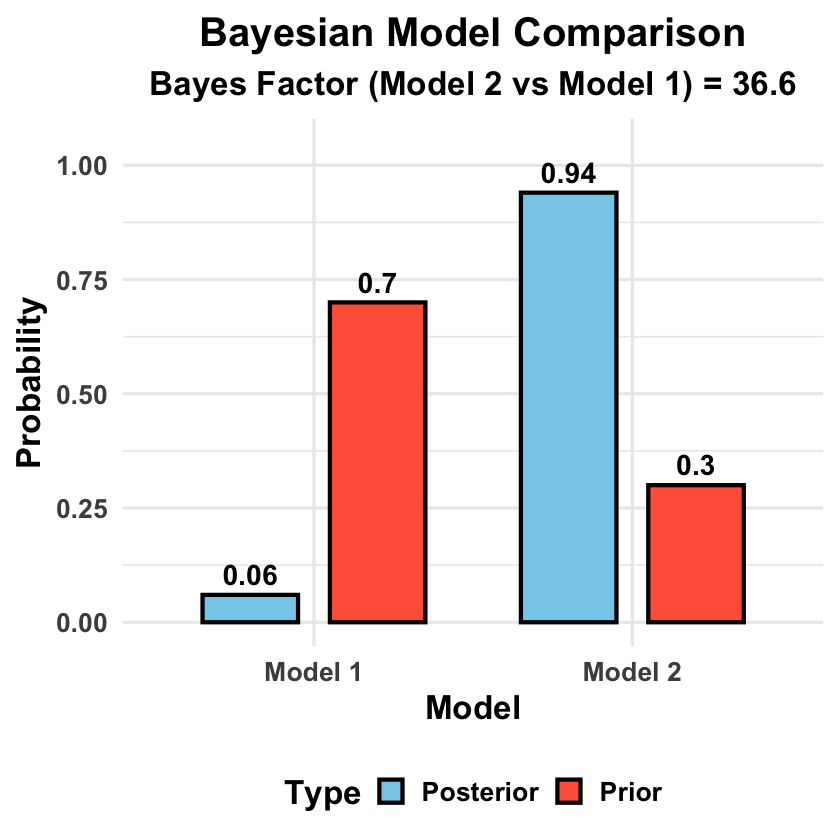

In [7]:
library(ggplot2)

# Basic model comparison data with unequal priors
model_data <- data.frame(
 Model = c("Model 1", "Model 2"),
 Log_Marginal_Likelihood = c(-152.3, -148.7),
 Prior_Probability = c(0.7, 0.3)  # Higher prior for Model 1
)

# Compute Bayes factor and posterior probabilities
bayes_factor <- exp(model_data$Log_Marginal_Likelihood[2] - model_data$Log_Marginal_Likelihood[1])
unnormalized_posteriors <- exp(model_data$Log_Marginal_Likelihood) * model_data$Prior_Probability
posterior_probs <- unnormalized_posteriors / sum(unnormalized_posteriors)

# Create plotting data
plot_data <- data.frame(
 Model = rep(c("Model 1", "Model 2"), 2),
 Probability = c(model_data$Prior_Probability, posterior_probs),
 Type = rep(c("Prior", "Posterior"), each = 2)
)

# Create barplot
p <- ggplot(plot_data, aes(x = Model, y = Probability, fill = Type)) +
 geom_col(position = position_dodge(width = 0.8), width = 0.6, color = "black", linewidth = 1.2) +
 geom_text(aes(label = round(Probability, 3)), 
           position = position_dodge(width = 0.8), vjust = -0.5, size = 6, fontface = "bold") +
 scale_fill_manual(values = c("Prior" = "tomato", "Posterior" = "skyblue")) +
 labs(
   title = "Bayesian Model Comparison",
   subtitle = paste("Bayes Factor (Model 2 vs Model 1) =", round(bayes_factor, 2)),
   y = "Probability",
   x = "Model",
   fill = "Type"
 ) +
 ylim(0, 1.05) +
 theme_minimal(base_size = 20) +
 theme(
   plot.title = element_text(hjust = 0.5, face = "bold"),
   plot.subtitle = element_text(hjust = 0.5, face = "bold"),
   axis.title.y = element_text(face = "bold"),
   axis.title.x = element_text(face = "bold"),
   axis.text.x = element_text(face = "bold"),
   axis.text.y = element_text(face = "bold"),
   legend.title = element_text(face = "bold"),
   legend.text = element_text(face = "bold"),
   legend.position = "bottom"
 )

print(p)

# Save the plot
ggsave("./cartoons/Bayesian_model_comparison.png", plot = p,
      width = 10, height = 6, 
      bg = "transparent",
      dpi = 300)